### Load Data

In [357]:
model_name = 'model_siamese_classification'
num_epochs = 50

In [358]:
import torch
import torch.nn.functional as F
import torch_geometric.transforms as T
from torch_geometric.loader import DenseDataLoader
from torch_geometric.loader import DataLoader 
from torch_geometric.nn import GCNConv, global_max_pool, global_mean_pool, global_add_pool
from torch_geometric.utils import dense_to_sparse
import math
import numpy as np

In [359]:
data_dir_1 = 'C:/Users/david/pyproj/pyg/adl/patch_label_1'
data_dir_0 = 'C:/Users/david/pyproj/pyg/adl/patch_label_0'
#data_dir_1 = 'adl_data_1'
#data_dir_0 = 'adl_data_0'

In [360]:
from c_PatchDataset_sparse import PatchDataset
dataset = PatchDataset(data_dir_label_0 = data_dir_0,  data_dir_label_1=data_dir_1,  neg_pos_ratio=1)
len(dataset)

572

In [361]:
print(f'Number of graphs pairs: {len(dataset)}')
data = dataset[0]  # Get the first graph object.
print(data)

Number of graphs pairs: 572
(Data(x=[100, 3], edge_index=[2, 596], y=1), Data(x=[100, 3], edge_index=[2, 592], y=1))


In [362]:
graph_dataset= []
for data in dataset:
    graph_dataset.append(data[0])
    graph_dataset.append(data[1])

In [363]:
from torch_geometric.data import Data

pair_data = []
couple_loader = DataLoader(dataset = graph_dataset, batch_size=2, shuffle=False)

for couple in couple_loader:
    y = couple.y[0].long()
    couple_graph = Data(x=couple.x, edge_index=couple.edge_index, y=y, original_batch = couple.batch)
    pair_data.append(couple_graph)

In [364]:
batch_size = 1

n_train = math.ceil((4/6) * len(dataset))
n_val = math.ceil((len(dataset) - n_train)/2)
n_test = len(dataset) - n_train - n_val

train_dataset, val_dataset, test_dataset = torch.utils.data.random_split(pair_data, [n_train, n_val, n_test])
print(f'Number of training graphs pairs: {len(train_dataset)}')
print(f'Number of validation graphs: {len(val_dataset)}')
print(f'Number of test graphs: {len(test_dataset)}')

train_loader = DataLoader(dataset = train_dataset, batch_size= batch_size, shuffle=True)
val_loader = DataLoader(dataset = val_dataset, batch_size= batch_size, shuffle=True)
test_loader = DataLoader(dataset = test_dataset, batch_size= batch_size, shuffle=True)

Number of training graphs pairs: 382
Number of validation graphs: 95
Number of test graphs: 95


In [365]:
databatch = next(iter(train_loader))
databatch

DataBatch(x=[200, 3], edge_index=[2, 1226], y=[1], original_batch=[200], batch=[200], ptr=[2])

In [366]:
databatch.original_batch

tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1])

### Define Loss Function

In [367]:
class ContrastiveLoss(torch.nn.Module):

    def __init__(self, margin=1.0):
        super(ContrastiveLoss, self).__init__()
        self.margin = margin

    def forward(self, x0, x1, y):

        diff = x0 - x1
        pow = torch.pow(diff, 2)
        dist_sq = torch.sum(pow, 0)
        dist = torch.sqrt(dist_sq) 
        mdist = self.margin - dist #negative euclidean distance - margin
        dist_marg = torch.clamp(mdist, min=0.0) # only distances <margin will be still positive here
        loss =  y * torch.pow(dist, 2) + (1-y) * torch.pow(dist_marg,2)
        
        #             Margin = 1            Margin = 2.0        Margin = 3.0
        # dist = 0.2  label 1 --> 0.04      --> 0.04            --> 0.04
        # dist = 0.2  label 0 --> 0.64      --> 3.24            --> 7.84
        #
        # dist = 0.5  label 1 --> 0.25      --> 0.25            --> 0.25
        # dist = 0.5  label 0 --> 0.25      --> 2.25            --> 6.25
        # 
        # dist = 1.0  label 1 --> 1.0       --> 1.0             --> 1.0 
        # dist = 1.0  label 0 --> 0         --> 1.0             --> 4.0
        #
        # dist = 1.5  label 1 --> 2.25      --> 2.25            --> 2.25
        # dist = 1.5  label 0 --> 0         --> 0.25            --> 2.25
        # 
        # dist = 3    label 1 --> 9         --> 9               --> 9
        # dist = 3    label 0 --> 0         --> 0               --> 0

        loss = loss / 2.0
        return loss

### Define Network

In [368]:
class GNN(torch.nn.Module):
    def __init__(self, in_channels, hidden_channels, out_channels,
                 normalize=False, lin=True):
        super(GNN, self).__init__()

               
        self.conv1 = GCNConv(in_channels, hidden_channels, normalize)
        self.conv2 = GCNConv(hidden_channels, hidden_channels, normalize)
        self.conv3 = GCNConv(hidden_channels, out_channels, normalize)


    def forward(self, x, edge_index):
        
        x = self.conv1(x, edge_index)
        x = self.conv2(x, edge_index)
        x = self.conv3(x, edge_index)

        return x


class ConvNet(torch.nn.Module):
    def __init__(self):
        super(ConvNet, self).__init__()

        self.gnn1 = GNN(dataset.num_features, 8, 16)
        self.gnn2 = GNN(16, 32, 64, lin=False)
        self.gnn3 = GNN(64, 96, 128, lin=False)

        self.lin1 = torch.nn.Linear(128, 64) 
        self.lin2 = torch.nn.Linear(64, 32)
        self.lin3 = torch.nn.Linear(32,2)


    def forward(self, x, adj, batch):
        
        x = self.gnn1(x, adj)
        x = self.gnn2(x, adj)
        x = self.gnn3(x, adj)

        #x = global_max_pool(x, batch)
        x = global_mean_pool(x, batch)
        #x = global_add_pool(x, batch)
        x = torch.sum(x, dim = 0)

        x = F.relu(self.lin1(x))
        x = F.relu(self.lin2(x))
        x = self.lin3(x)

        log = F.log_softmax(x, dim=-1)

        return log

In [369]:
def count_parameters(model, trainable=True):
    return sum(p.numel() for p in model.parameters() if p.requires_grad or not trainable)

### Training

In [370]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)
model = ConvNet().to(device)
criterion = ContrastiveLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.0001)



def train(epoch):
    model.train()
    loss_all = 0
    for data in train_loader:
        data = data.to(device)
        optimizer.zero_grad()
        output = model(data.x, data.edge_index, data.original_batch)
        output = torch.unsqueeze(output, 0)

        loss = F.nll_loss(output, data.y.view(-1))
        loss.backward()
        loss_all += data.y.size(0) * loss.item()
        optimizer.step()

    return loss_all / len(train_dataset)



@torch.no_grad()
def test(loader):
    model.eval()
    test_loss_all = 0
    correct = 0

    for data in loader:
        data = data.to(device)
        output = model(data.x, data.edge_index, data.original_batch)
        output = torch.unsqueeze(output, 0)

        # Compute Accuracy
        pred = output.max(dim=1)[1]
        correct += pred.eq(data.y.view(-1)).sum().item()

        # Compute Loss
        test_loss = F.nll_loss(output, data.y.view(-1))
        test_loss_all += data.y.size(0) * test_loss.item()      

    return  correct / len(loader.dataset), test_loss_all / len(loader.dataset)



tr_loss = []
tr_acc = []
v_loss = []
v_acc = []
tst_loss = []
tst_acc = []

min_val_loss = 100

parameters = count_parameters(model)
with open(f'{model_name}_output.txt', 'w') as f:
    f.write(f'Training Data ({model_name}):\n')
    f.write(f'Number of Parameters: {parameters}\n')
    f.close()


for epoch in range(1,num_epochs+1):
    
    loss = train(epoch)
    #tr_loss.append(train_loss)

    train_acc, train_loss = test(train_loader)
    tr_loss.append(train_loss)
    tr_acc.append(train_acc)

    val_acc, val_loss = test(val_loader)
    v_loss.append(val_loss)
    v_acc.append(val_acc)

    test_acc, test_loss = test(test_loader)
    tst_loss.append(test_loss)
    tst_acc.append(test_acc)

    printout = (f'E{epoch:03d}, Train Loss: {train_loss:.3f}, Val Loss: {val_loss:.3f}, Test Loss: {test_loss:.3f}, '
         f'Train Acc: {train_acc:.3f}, Val Acc: {val_acc:.3f}, Test Acc: {test_acc:.3f}')
    
    # append to outputs txt
    with open(f'{model_name}_output.txt', 'a') as f:
        f.write(printout + '\n')
        f.close()

    print(printout)

    # Save the model outputs
    np.save(f'{model_name}_training_loss.npy', tr_loss, allow_pickle=True)
    np.save(f'{model_name}_training_accuracy.npy', tr_acc, allow_pickle=True)

    np.save(f'{model_name}_validation_loss.npy', v_loss, allow_pickle=True)
    np.save(f'{model_name}_validation_accuracy.npy', v_acc, allow_pickle=True)

    np.save(f'{model_name}_test_loss.npy', tst_loss, allow_pickle=True)
    np.save(f'{model_name}_test_accuracy.npy', tst_acc, allow_pickle=True)

    last_saved_epoch = epoch


    # If the epoch has improved the model, save it
    if (val_loss + test_loss)/2 < min_val_loss:
        new_best = True
        min_val_loss = (val_loss + test_loss)/2
        best_epoch = epoch
    else:
        new_best = False

    if new_best:
        torch.save(model.state_dict(), f'{model_name}_state_dict_best.pt')
        torch.save(model, f'{model_name}_best.pt')

   
    


cpu
E001, Train Loss: 0.541, Val Loss: 0.521, Test Loss: 0.573, Train Acc: 0.754, Val Acc: 0.747, Test Acc: 0.695
E002, Train Loss: 0.534, Val Loss: 0.507, Test Loss: 0.585, Train Acc: 0.751, Val Acc: 0.758, Test Acc: 0.705
E003, Train Loss: 0.534, Val Loss: 0.509, Test Loss: 0.590, Train Acc: 0.751, Val Acc: 0.758, Test Acc: 0.695
E004, Train Loss: 0.534, Val Loss: 0.512, Test Loss: 0.577, Train Acc: 0.757, Val Acc: 0.758, Test Acc: 0.684
E005, Train Loss: 0.533, Val Loss: 0.510, Test Loss: 0.575, Train Acc: 0.751, Val Acc: 0.758, Test Acc: 0.695
E006, Train Loss: 0.532, Val Loss: 0.506, Test Loss: 0.573, Train Acc: 0.757, Val Acc: 0.758, Test Acc: 0.695
E007, Train Loss: 0.532, Val Loss: 0.504, Test Loss: 0.585, Train Acc: 0.751, Val Acc: 0.758, Test Acc: 0.705
E008, Train Loss: 0.530, Val Loss: 0.504, Test Loss: 0.581, Train Acc: 0.754, Val Acc: 0.758, Test Acc: 0.695
E009, Train Loss: 0.533, Val Loss: 0.501, Test Loss: 0.570, Train Acc: 0.754, Val Acc: 0.758, Test Acc: 0.726
E010, 

### Evaluation

In [371]:
import numpy as np
training_loss = np.load(f'{model_name}_training_loss.npy', allow_pickle=True)
training_accuracy = np.load(f'{model_name}_training_accuracy.npy', allow_pickle=True)

validation_loss = np.load(f'{model_name}_validation_loss.npy', allow_pickle=True)
validation_accuracy = np.load(f'{model_name}_validation_accuracy.npy', allow_pickle=True)

test_loss = np.load(f'{model_name}_test_loss.npy', allow_pickle=True)
test_accuracy = np.load(f'{model_name}_test_accuracy.npy', allow_pickle=True)

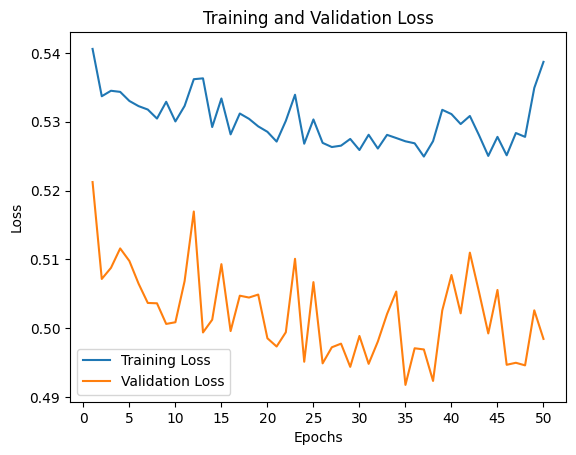

In [372]:
import matplotlib.pyplot as plt

# Generate a sequence of integers to represent the epoch numbers
epochs = range(1, last_saved_epoch+1)
 
# Plot and label the training and validation loss values
plt.plot(epochs, training_loss, label='Training Loss')
plt.plot(epochs, validation_loss, label='Validation Loss')
 
# Add in a title and axes labels
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
 
# Set the tick locations
plt.xticks(np.arange(0, last_saved_epoch+1, last_saved_epoch/10))
 
# Display the plot
plt.legend(loc='best')
plt.savefig(f'{model_name}_plot_loss.png')
plt.show()

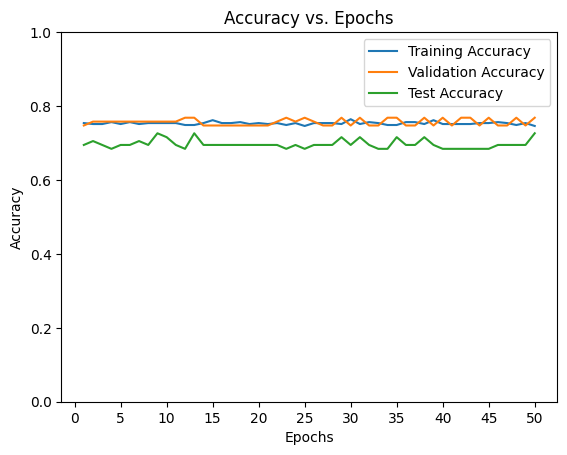

In [373]:
import matplotlib.pyplot as plt

# Generate a sequence of integers to represent the epoch numbers
epochs = range(1, last_saved_epoch+1)
 
# Plot and label the training and validation loss values
plt.plot(epochs, training_accuracy, label='Training Accuracy')
plt.plot(epochs, validation_accuracy, label='Validation Accuracy')
plt.plot(epochs, test_accuracy, label='Test Accuracy')
 
# Add in a title and axes labels
plt.title('Accuracy vs. Epochs')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
 
# Set the tick locations
plt.xticks(np.arange(0, last_saved_epoch+1, last_saved_epoch/10))
plt.ylim(0,1)
 
# Display the plot
plt.legend(loc='best')
plt.savefig(f'{model_name}_Accuracy vs. Epochs.png')
plt.show()